In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE

# Persiapan Dataframe

In [3]:
# Import the reviews.csv file
reviews_df = pd.read_csv('reviews.csv')
# print(reviews_df.head())

# Labelling

In [5]:
from transformers import pipeline

pretrained_name = "w11wo/indonesian-roberta-base-indolem-sentiment-classifier-fold-0"

nlp = pipeline(
    "sentiment-analysis",
    model=pretrained_name,
    tokenizer=pretrained_name
)

nlp("Pelayanan hotel ini sangat baik.")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


: 

# EDA

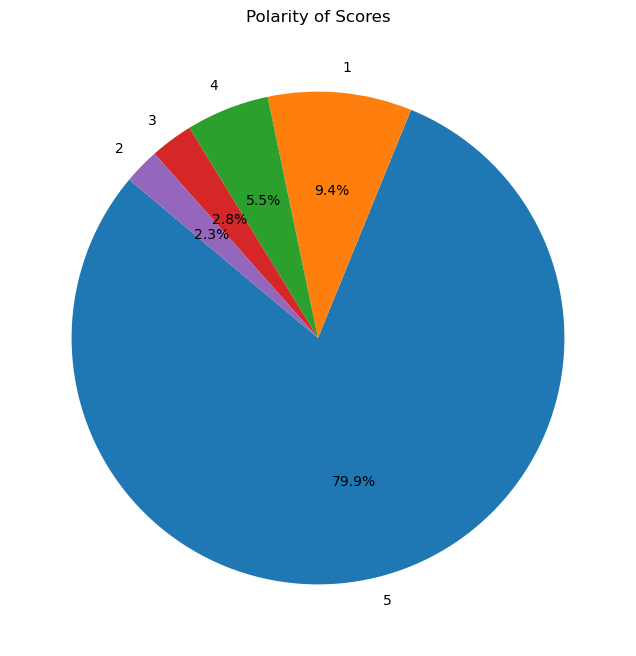

In [4]:
# Count the occurrences of each score
score_counts = reviews_df['score'].value_counts()

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(score_counts, labels=score_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Polarity of Scores')
plt.show()